# Exploratory Analysis
#### Brian Bahmanyar

***

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.dates import *
import seaborn as sns

import statsmodels.api as sm

from helpers import *
from plots import *

/Users/bbahmany/Main/Programming/Git/quantitative-finance/qf-env/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [10]:
%matplotlib inline
sns.set_style("whitegrid", {'axes.edgecolor': '.6', 
                            'axes.facecolor': '0.9', 
                            'grid.color': '.82', 
                            'legend.frameon': True,
                            'axes.labelsize': 'small'})
#sns.set_context("talk")

In [3]:
Quandl.get('WIKI/'+'FB', trim_start='2014-1-1')['Adj. Close']

ErrorDownloading: Error Downloading! HTTP Error 429: Too Many Requests

In [2]:
portfolio = get_adj_close( ['FB', 'AMZN', 'CMG', 'VZ', 'T'], 
                           start='2013-01-01', 
                           ratios=[('FB','AMZN'), ('FB','CMG'), ('VZ', 'T')],
                           log_transforms=['FB', 'CMG'] )

NameError: name 'DatasetNotFound' is not defined

In [6]:
portfolio.head()

,AMZN,AMZN/FB,CMG,CMG/FB,FB,T,VZ,VZ/T,ln(CMG),ln(FB)
Date,,,,,,,,,,
2013-01-02,257.31,9.189643,301.06,10.752143,28.00,30.260352,41.463123,1.370213,5.707310,3.332205
2013-01-03,258.48,9.307886,300.95,10.837234,27.77,30.277644,41.266437,1.362934,5.706944,3.323956
2013-01-04,259.15,9.010779,300.18,10.437413,28.76,30.459206,41.491221,1.362190,5.704382,3.358986
2013-01-07,268.46,9.125085,299.59,10.183209,29.42,30.597539,41.856493,1.367969,5.702415,3.381675
2013-01-08,266.38,9.166552,297.76,10.246387,29.06,30.087436,40.849652,1.357698,5.696288,3.369363


In [84]:
def plot_stocks(index, stocks, labels, positions=None, label_annually=True):
    """
    Plots up to 5 stocks
    
    Args:
        index (DateTimeIndex): date range
        stocks (list): list of stocks to plot
        labels (list): labels to use for plotting
        positions (list of dicts): optional postions to overplot
        label_annually (boolean): plots x label monthly if false, annually otherwise
        
    Returns (None): Will output plot inline
    """
    colors = ['firebrick','steelblue','orange','mediumorchid', 'mediumseagreen']
    
    fig, ax = plt.subplots(figsize=(20,8));
    
    if label_annually:
        span = YearLocator();
        my_format = DateFormatter('%Y');
    else:
        span = MonthLocator();
        my_format = DateFormatter('%b %Y');    
    
    ax.xaxis.set_major_locator(span);
    ax.xaxis.set_major_formatter(my_format);
    ax.autoscale_view();
    
    plt.title('Adjusted Close Prices', fontsize=20);
    plt.ylabel('Adj. Close', fontsize=15);
    plt.xlabel('Time', fontsize=15);
    
    for stock, label, color in zip(stocks, labels, colors):
        ax.plot_date(index, stock, color=color, linestyle='-', marker=None, label=label);
        plt.xticks(rotation=45)
    
    if positions:
        for position in positions:
            ax.axvline(df.index[position['open']], color='lime', linestyle='-')
            ax.axvline(df.index[position['close']], color='red', linestyle='-')
 
    plt.legend(loc=2, prop={'size':15}, frameon=True);

Exploring trend and randomness of the prices over time: 

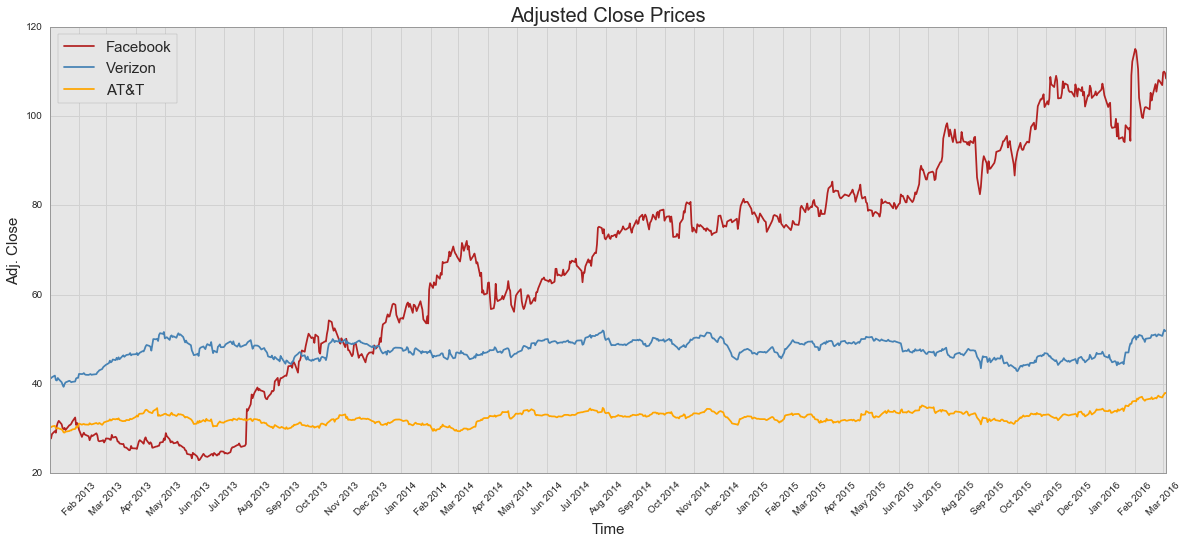

In [86]:
plot_stocks(portfolio.index, 
            [portfolio['FB'], portfolio['VZ'], portfolio['T']], 
            ['Facebook', 'Verizon', 'AT&T'], 
            label_annually=False)

It is important to look at the detrended data to identify any autocorrelation structure in the series. A common approach to detrending data is taking a differences of your series until it becomes [stationary](https://en.wikipedia.org/wiki/Stationary_process). 

In [106]:
def get_lagged_series(series, order=1, log=False):
    lagged = None
    if log:
        lagged = np.log(series).diff(order).dropna();
    else:
        lagged = series.diff(order).dropna();
    
    return lagged

In [107]:
def plot_lagged_series(series, order=1, log=False):
    """
    Plots lagged series
    
    Args:
        series (ndarray): time series
        order (int): the order of the difference
        log (boolean): whether to log transform before difference
    
    Returns (None): plots inline
    """
    plt.figure(figsize=(8,4));
    plt.xlabel('Time Index');
    plt.ylabel('Difference');
    
    if log:
        plt.title('Log Series Lagged by ' + str(order));
        lagged = get_lagged_series(series, order, log)
    else:
        plt.title('Series Lagged by ' + str(order));
        lagged = get_lagged_series(series, order, log)
        
    plt.plot(np.arange(0,lagged.size,1), lagged);

The series seems to be approximatley stationary after a first difference, but there is some unequal variance which we can address with a log transformation.

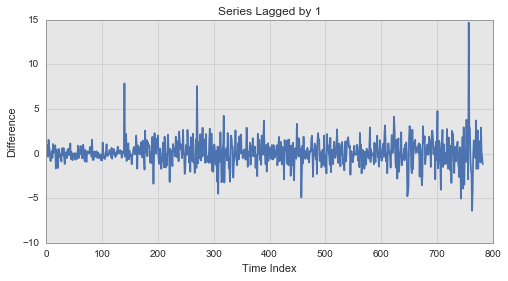

In [108]:
plot_lagged_series(portfolio.FB)

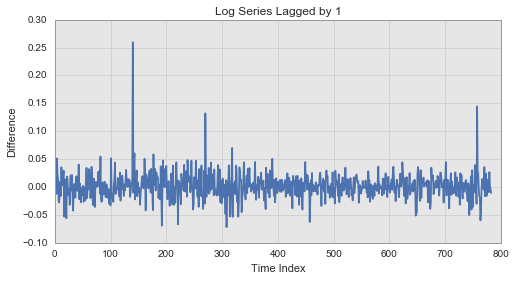

In [109]:
plot_lagged_series(portfolio.FB, log=True)

Plotting the autocorrelations and partial autocorrelations in the log of Facebook's prices over the past 100 trading days :

In [113]:
def plot_correlograms(series, limit=50):
    fig = plt.figure(figsize=(15,8));
    ax1 = fig.add_subplot(211);
    fig = sm.graphics.tsa.plot_acf(series, lags=limit, ax=ax1);
    plt.title('Correlogram');
    plt.xticks(np.arange(0,limit+1,1))
    plt.xlim([-1,limit])
    
    ax2 = fig.add_subplot(212);
    fig = sm.graphics.tsa.plot_pacf(series, lags=limit, ax=ax2);
    plt.title('Partial Correlogram');
    plt.xticks(np.arange(0,limit+1,1))
    plt.xlim([-1,limit])

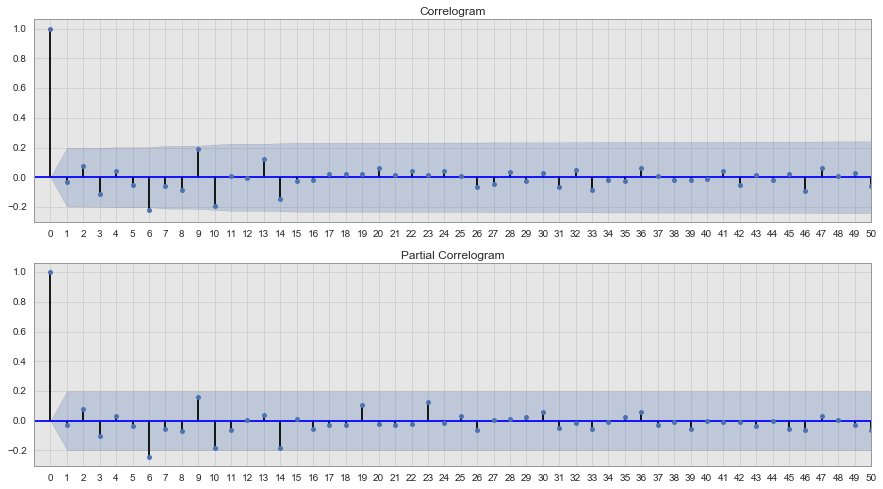

In [115]:
plot_correlograms(get_lagged_series(portfolio.FB[-100:], log=True))

Although there are some intital significant lags, nothing really jumps out at me. Identifying patterns in these plots are key to fitting the appropriate model in the next notebook.

All the plotting functions above have been copied into _viz.py_ for use in other notebooks.